# 01 Data Preprocess
The Amazon Bin Image Dataset contains total 536,434 jpeg image file, and its metadata file, of the bins in the operating Amazon fulfilment center. 
The data will first go through EDA. 
The data qualified for Model Evaluation and Training will be recorded into a dataframe. 

---
### 1. Import Libraries and variable setting


In [1]:
import json
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import cv2
import os
import pickle

import skimage
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import gabor_kernel
from sklearn.preprocessing import MinMaxScaler

In [5]:
# !pip install scikit-image

In [2]:
image_source_dir = '../data/bin-images-224x224'
data_dir = '../data'

---
### 2. Extract Metadata

Amazon Bin Image Dataset comes with a metadata file, which contains description of the product SKU information (i.e. description, dimension, etc) of the items in the bin, the quantities of each product, and the total quantity of all items in the bin. The metadata file is a SQLite DB. Each data row is for 1 image file and its metadata information in a JSON format. 

Sample of the JSON metadata for 00001.jpg
```
{
  "BIN_FCSKU_DATA": {
    "B000C33MI2": {
      "asin": "B000C33MI2",
      "height": {
        "unit": "IN",
        "value": 2.79921259557
      },
      "length": {
        "unit": "IN",
        "value": 3.90157479917
       },
      "name": "FRAM XG7317 ULTRA Spin-On Oil Filter with Sure Grip",
      "normalizedName": "FRAM XG7317 ULTRA Spin-On Oil Filter with Sure Grip",
      "quantity": 4,
      "weight": {
        "unit": "pounds",
        "value": 0.3000050461296
      },
      "width": {
        "unit": "IN",
        "value": 2.90157480019
      }
    },
    "B0050Z27KG": {
      "asin": "B0050Z27KG",
      "height": {
        "unit": "IN",
        "value": 0.899999999082
      },
      "length": { 
        "unit": "IN",
        "value": 11.299999988474
      },
      "name": "Suncatcher - Axicon Rainbow Window - Includes Bonus \"Rainbow on Board\" Sun Catcher",
      "normalizedName": "Suncatcher - Axicon Rainbow Window - Includes Bonus \"Rainbow on Board\" Sun Catcher",
      "quantity": 2,
      "weight": {
        "unit": "pounds",
        "value": 0.5
      },
      "width": {
        "unit": "IN",
        "value": 7.699999992146
      }
    },
    "B01BV89HNU": {
      "asin": "B01BV89HNU",
      "height": {
        "unit": "IN",
        "value": 2.1999999977560005
      },
      "length": {
        "unit": "IN",
        "value": 3.99999999592
      },
     "name": "Type C, iOrange-E 2 Pack 6.6 Ft Braided Cable for Nexus 6P, ... Nokia N1   Tablet and Other USB C Devices, Black",
     "normalizedName": "2 Pack Type C, iOrange-E 6.6 Ft Braided Cable for ... Nokia N1 Tablet and Other USB C Devices, Black",
     "quantity": 6,
     "weight": {
       "unit": "pounds",
       "value": 0.3499999997064932
     },
     "width": {
       "unit": "IN",
       "value": 3.899999996022
     }
   }
 },
 "EXPECTED_QUANTITY": 12
 }
 ```
- Attribute `BIN_FCSKU_DATA` carries the SKUs (Stock Keeping Unit, i.e. product model) available in the bin. The SKU details, such as description, quantity, dimension, etc is provided in the Level 2- 4 attributes. 
- Attribute `EXPECTED_QUANTITY` is the items available in the bin. This will be used as the label for the bin.




Connect to metadata db using sqlite3 connection, and fetch all data into memory

In [3]:
conn = sqlite3.connect(f"{data_dir}/metadata.db")
cursor= conn.cursor()
cursor.execute("SELECT * FROM metadata")
rows = cursor.fetchall()

The metadata information will be extracted into 3 data structures for further analysis and downstream processing. Data structure where data is extracted from metadata. 
1. Bin SKU - { 'BinID' : 'SKU', "SKU_Qty_in_Bin'}  - carry information about what are the SKU (and its Quantity) in a Bin
2. Inventory supply - { 'SKU':'Total_SKU_Qty'} - carry information from SKU perspective, what are the supply quantity available (across all Bins)
3. Bin Inventory - { 'BinID': 'Bin_total_Qty' } - carry information about how many total quantity in each Bin 

Note - the jpeg filename will be treated as BinID (identifier for a Bin) throughout the notebook

In [4]:
count = 0 
inv_supply = {}
bin_sku = {}
metadata_list = []

for filename, json_message in rows:
    metadata = {}
    data = json.loads(json_message)

    metadata['bin_fcsku_data'] = data.get("BIN_FCSKU_DATA", {})
    metadata['expected_quantity'] = data.get("EXPECTED_QUANTITY", 0)
    metadata['image_fname'] = data.get("image_fname", filename) 

    if metadata['expected_quantity'] > 0: 
        metadata['sku_count'] = len(metadata['bin_fcsku_data'])
    else:
        metadata['sku_count'] = 0

    metadata_list.append(metadata)

    file_name = data.get("image_fname", filename)
    for sku, sku_dict in data.get("BIN_FCSKU_DATA").items():

        # create (new) or update (exist) qty of the inventory_supply for SKU
        if sku in inv_supply:
            inv_supply[sku] += sku_dict['quantity']
        else:
            inv_supply[sku] = sku_dict['quantity']
        
        #initialize bin_sku for this filename
        if file_name not in bin_sku:
            bin_sku[file_name] = {}
        
        # Assume a filename only appear once in the metadata. If appear more than once, then take the qty from the latest. 
        bin_sku[file_name][sku] = sku_dict['quantity']

`metadata_list` contains list of metadata, where each record is for one Bin, and how many SKUs and how many total Quantity (i.e. expected_quantity) are there in the bin.  

In [5]:
bin_inv_df = pd.DataFrame(metadata_list)
bin_inv_df.head(5)

,bin_fcsku_data,expected_quantity,image_fname,sku_count
0,"{'B000C33MI2': {'asin': 'B000C33MI2', 'height'...",12,00001.jpg,3
1,{},0,1.jpg,0
2,"{'0307981584': {'asin': '0307981584', 'height'...",17,00002.jpg,3
3,{},0,2.jpg,0
4,"{'0307981584': {'asin': '0307981584', 'height'...",16,00003.jpg,3


Total there are 536,434 Bins

In [6]:
bin_inv_df.shape

(536434, 4)

The distribution of the item quantity (show top 20)

In [7]:
vc = bin_inv_df['expected_quantity'].value_counts(normalize=True).sort_index(ascending=True).head(20)
print(vc*100)

expected_quantity
0      1.845707
1      7.707752
2     14.365793
3     16.825555
4     15.053110
5     11.678604
6      8.585958
7      6.279244
8      4.514814
9      3.224628
10     2.390415
11     1.711115
12     1.274528
13     0.967687
14     0.680046
15     0.519542
16     0.405455
17     0.323059
18     0.243087
19     0.203939
Name: proportion, dtype: float64


In [8]:
bin_inv_df.isnull().sum()

bin_fcsku_data       0
expected_quantity    0
image_fname          0
sku_count            0
dtype: int64

In [9]:
bin_inv_df.describe()

,expected_quantity,sku_count
count,536434.000000,536434.000000
mean,5.107281,2.639176
std,4.620148,1.377005
min,0.000000,0.000000
25%,3.000000,2.000000
50%,4.000000,2.000000
75%,6.000000,3.000000
max,209.000000,22.000000


`inventory_supply` contains the list of SKUs and the total quantity of this SKUs in the warehouse (known as Supply Qty, i.e. SKU_supply_qty), regardless of the Bins

In [10]:
inv_supply_df = pd.DataFrame(list(inv_supply.items()), columns=['SKU','SKU_supply_qty'])
inv_supply_df.sort_values('SKU_supply_qty', ascending=False).head(5)

,SKU,SKU_supply_qty
16562,B01CZ54L66,2704
101117,B00P3DUFRW,1981
29442,B00VF0MCCS,1743
26881,B00CIECDEM,1677
28901,B00IVPU7AO,1577


In [15]:
inv_supply_df.shape

(460515, 2)

In [16]:
inv_supply_df.isnull().sum()

SKU               0
SKU_supply_qty    0
dtype: int64

In [17]:
inv_supply_df.describe()

,SKU_supply_qty
count,460515.000000
mean,5.948653
std,18.504558
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,2704.000000


`bin_sku` contains the list of SKU available in each bin, the SKU's available quantity. 

In [11]:
bin_sku_list = []
for fname, sku_dict in bin_sku.items():
    for sku, qty in sku_dict.items():
        bin_sku_list.append([fname, sku, qty])

bin_sku_df = pd.DataFrame(bin_sku_list, columns=['image_fname','sku','bin_sku_qty'])


In [12]:
bin_sku_df.sort_values('bin_sku_qty',ascending=False).head(5)

,image_fname,sku,bin_sku_qty
223054,83502.jpg,B01CZ54L66,209
223055,83503.jpg,B01CZ54L66,207
693966,261770.jpg,B00BXLVD8I,187
1344111,508221.jpg,B00NVUDIZ0,185
1344110,508220.jpg,B00NVUDIZ0,185


In [20]:
bin_sku_df.shape

(1415744, 3)

In [21]:
bin_sku_df.isnull().sum()

image_fname    0
sku            0
bin_sku_qty    0
dtype: int64

In [22]:
bin_sku_df.describe()

,bin_sku_qty
count,1.415744e+06
mean,1.934985e+00
std,2.702131e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,2.090000e+02


In [23]:
bin_inv_df_not_empty = bin_inv_df[bin_inv_df['sku_count'] > 0]
bin_inv_df_not_empty.describe()

,expected_quantity,sku_count
count,526533.000000,526533.000000
mean,5.203319,2.688804
std,4.609494,1.341029
min,1.000000,1.000000
25%,3.000000,2.000000
50%,4.000000,2.000000
75%,6.000000,3.000000
max,209.000000,22.000000


Export the 3 set of data - Inventory Supply, Bin SKU, Bin Inventory to CSV 

In [28]:
bin_inv_df.to_csv(f'{data_dir}/metadata_bin_inventory.csv', index=False)
inv_supply_df.to_csv(f'{data_dir}/metadata_inventory_supply.csv', index=False)
bin_sku_df.to_csv(f'{data_dir}/metadata_bin_sku.csv', index=False)


---
### 3. EDA

`bin_inv_df` - each record is for one Bin, and how many SKUs and how many total Quantity (i.e. expected_quantity) are there in the bin.  

In [29]:
bin_inv_df.head(5)

,bin_fcsku_data,expected_quantity,image_fname,sku_count
0,"{'B000C33MI2': {'asin': 'B000C33MI2', 'height'...",12,00001.jpg,3
1,{},0,1.jpg,0
2,"{'0307981584': {'asin': '0307981584', 'height'...",17,00002.jpg,3
3,{},0,2.jpg,0
4,"{'0307981584': {'asin': '0307981584', 'height'...",16,00003.jpg,3


In [30]:
bin_inv_df['sku_count'].max()

22

maximum number of SKU available in a bin is 22

<function matplotlib.pyplot.show(close=None, block=None)>

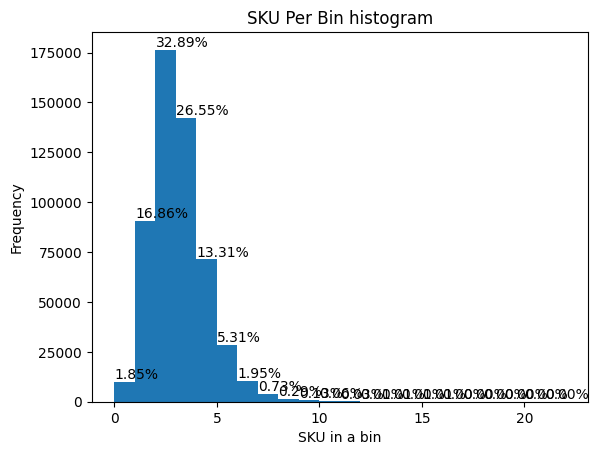

In [31]:
bin_count, bin_edge = np.histogram(bin_inv_df['sku_count'], bins = 22)
total_count = np.sum(bin_count)
percentage = ( bin_count / total_count) * 100
plt.hist(bin_inv_df['sku_count'], bins = bin_edge, label='Data')
for i in range(len(bin_count)):
    plt.text(bin_edge[i], bin_count[i], f'{percentage[i]:.2f}%', va='bottom')

# plt.hist(bin_inv_df['expected_quantity'], bins = 10)
plt.xlabel("SKU in a bin")
plt.ylabel("Frequency")
plt.title("SKU Per Bin histogram")
plt.show

76.3% of the Bins have not more than 3 SKUs. 
1 SKU - 16.86%
2 SKUs - 32.89%
3 SKUs - 26.55%

<Axes: ylabel='sku_count'>

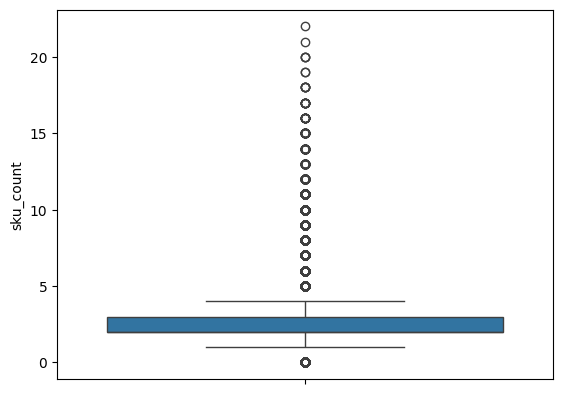

In [32]:
sns.boxplot(bin_inv_df['sku_count'])

5 SKUs and above in a bin is considered outlier. 
However, 0 SKUs (i.e. empty bin) should not be treated as outlier, because 0 qty is a valid counting class, i.e.to be able to recognize a bin is empty during cycle counting. 

In [33]:
bin_inv_df['expected_quantity'].max()

209

maximum expected_quantity is 209. Grouping 5 Qty as one histogram bucket (therefore total 42 histogram bucket)

<function matplotlib.pyplot.show(close=None, block=None)>

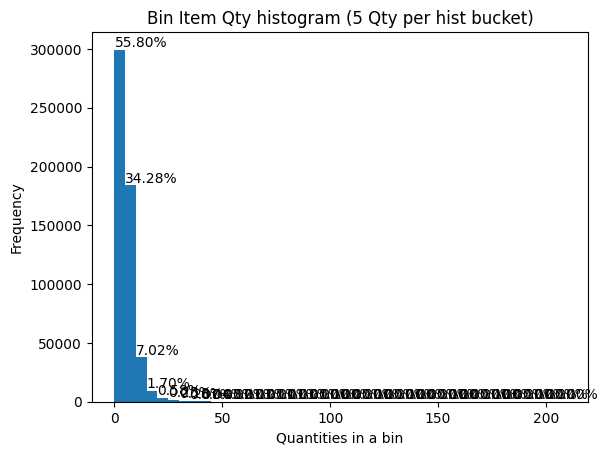

In [34]:
bin_count, bin_edge = np.histogram(bin_inv_df['expected_quantity'], bins = 42)
total_count = np.sum(bin_count)
percentage = ( bin_count / total_count) * 100
plt.hist(bin_inv_df['expected_quantity'], bins = bin_edge, label='Data')
for i in range(len(bin_count)):
    plt.text(bin_edge[i], bin_count[i], f'{percentage[i]:.2f}%', va='bottom')

# plt.hist(df['expected_quantity'], bins = 10)
plt.title("Bin Item Qty histogram (5 Qty per hist bucket)")
plt.xlabel("Quantities in a bin")
plt.ylabel("Frequency")
plt.show

More than half of the bins (55.8%) are having 5 quantity and below. 

In [35]:
bin_inv_df['expected_quantity'].mean()

5.107280671993199

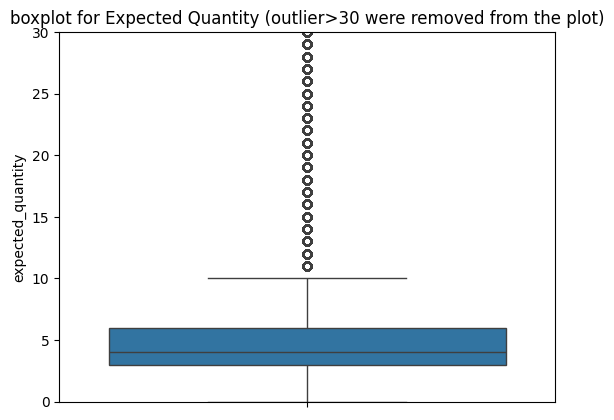

In [36]:
ax =sns.boxplot(bin_inv_df['expected_quantity'])
ax.set_ylim(0, 30)
plt.title('boxplot for Expected Quantity (outlier>30 were removed from the plot)')
plt.show()

The average quantity in a bin is 5.1. The distribution of the expected quantity is highly right skew. 

> More than half of the bins are having 5 quantity and below. Based on the Amazon Bin Image Challenge (https://github.com/silverbottlep/abid_challenge), counting bin quantity up to 5 objects is considered moderate difficulty. In this project, I will attempt to count up to 5 Quantity. 

In [19]:
sku_location_counts.max()

547

In [26]:
sku_location_counts = bin_sku_df.groupby('sku')['image_fname'].nunique()
location_count_frequency = sku_location_counts.value_counts().sort_index()
location_count_percentage = (location_count_frequency / location_count_frequency.sum()) * 100
summary_data = {
    'Number of Locations': [],
    'Percentage of SKUs': []
}

for i in range(1, 11):
    if i in location_count_percentage:
        summary_data['Number of Locations'].append(i)
        summary_data['Percentage of SKUs'].append(location_count_percentage[i])
        
# Add a single entry for counts > 10
greater_than_10_percentage = location_count_percentage[location_count_percentage.index > 10].sum()
summary_data['Number of Locations'].append('>10')
summary_data['Percentage of SKUs'].append(greater_than_10_percentage)

# Create the summary DataFrame
summary_table = pd.DataFrame(summary_data)
summary_table

,Number of Locations,Percentage of SKUs
0,1,35.840309
1,2,35.692866
2,3,9.531068
3,4,5.700140
4,5,3.008154
5,6,2.226420
6,7,1.442298
7,8,1.101376
8,9,0.838843
9,10,0.661216


Based on the above, almost 70% of the SKUs are placed within 1 or 2 Bin Locations only, while another 9.53% of the SKUs are placed in 3 Bin locations. This shows that each Bin Image are highly not identical in terms of the object type, with a SKU likely only appears in 1-3 Bin Locations most of the time.   

--- 
### 4. Filter out the blurred images

Preparing parameters and variables 

In [87]:
# define how many image samples to collect per class
sample_per_class = 200

# define the target value (i.e. qty count) per class. Array size is the number of class to classify
# class_num = [2,5]
class_num = [0,1,2,3,4,5]

# labels classes are multiclass value from 0, 1, 2, .... 
# class_label_map will map the "qty count" to "label", countinous running number starting from 0 
def class_labels(num):
        return { n:i for i,n in enumerate(num)}

class_label_map = class_labels(class_num)

quick validation of the class label mapping

In [38]:
print(class_label_map)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}


Load and verify Bin Inventory, which carry information about how many total quantity in each Bin 


In [39]:
metadata_df = pd.read_csv(f'{data_dir}/metadata_bin_inventory.csv')
metadata_df.head(3)

,bin_fcsku_data,expected_quantity,image_fname,sku_count
0,"{'B000C33MI2': {'asin': 'B000C33MI2', 'height'...",12,00001.jpg,3
1,{},0,1.jpg,0
2,"{'0307981584': {'asin': '0307981584', 'height'...",17,00002.jpg,3


In [40]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536434 entries, 0 to 536433
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   bin_fcsku_data     536434 non-null  object
 1   expected_quantity  536434 non-null  int64 
 2   image_fname        536434 non-null  object
 3   sku_count          536434 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 16.4+ MB


filter out only the data rows that meet the "class_num" requirements defined 

In [88]:
metadata_classes_df = metadata_df[(metadata_df['expected_quantity'].isin(class_num))] 
metadata_classes_df.head(5)

,bin_fcsku_data,expected_quantity,image_fname,sku_count
1,{},0,1.jpg,0
3,{},0,2.jpg,0
5,{},0,3.jpg,0
6,"{'B003E72M1G': {'asin': 'B003E72M1G', 'height'...",5,00004.jpg,3
7,{},0,4.jpg,0


Sampling the bin images. For model evaluation and testing purpose, only a subset of the full dataset will be required. The number of records to be sampled is configured in parameter `sample_per_class`, where each class (i.e. expected_quantity) will be sampled up to the `sample_per_class`, or the maximum available data set for the class, whichever minimal. 

In [89]:
def sampling_rows(group):
    return group.sample(n=min(len(group), sample_per_class)) 

# using the groupby, together with sampling_rows function, to sample out "sample per class" images  
sampled_metadata_df = metadata_classes_df.groupby('expected_quantity', group_keys=False).apply(sampling_rows)

# to randomize the row index. 
sampled_metadata_df = sampled_metadata_df.sample(frac=1, random_state=42).reset_index(drop=True)
sampled_metadata_df.head(10)

C:\Users\Ryan\AppData\Local\Temp\ipykernel_18524\2009863497.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_metadata_df = metadata_classes_df.groupby('expected_quantity', group_keys=False).apply(sampling_rows)


,bin_fcsku_data,expected_quantity,image_fname,sku_count
0,"{'086597375X': {'asin': '086597375X', 'height'...",5,115430.jpg,4
1,"{'B003XV379E': {'asin': 'B003XV379E', 'height'...",4,323322.jpg,3
2,{},0,231983.jpg,0
3,"{'B00RT9SFRK': {'asin': 'B00RT9SFRK', 'height'...",2,89155.jpg,2
4,{},0,21009.jpg,0
5,"{'B009ETMR86': {'asin': 'B009ETMR86', 'height'...",5,329485.jpg,3
6,"{'B00NLNLC3C': {'asin': 'B00NLNLC3C', 'height'...",1,270764.jpg,1
7,"{'B00CPV4ZB2': {'asin': 'B00CPV4ZB2', 'height'...",4,141435.jpg,2
8,"{'B013GUE92K': {'asin': 'B013GUE92K', 'height'...",2,35024.jpg,2
9,"{'B003T0ICCG': {'asin': 'B003T0ICCG', 'height'...",4,309370.jpg,4


In [91]:
sampled_metadata_df['expected_quantity'].value_counts()

expected_quantity
5    200
4    200
0    200
2    200
1    200
3    200
Name: count, dtype: int64

The sampled images are analyzed the following:
1. RGB distribution
2. Grayscale distribution
3. Texture analysis


Texture analysis in image analysis is used to characterize and describe the spatial arrangement of intensity or color in an image. It provides valuable information about the surface properties of objects within an image, such as roughness, smoothness, coarseness, or regularity. Texture analysis is widely used in various fields, including medical imaging, remote sensing, material science, and computer vision.

Gabor filters are commonly used in texture analysis to extract texture features from images. Gabor filters are a family of linear filters tuned to specific frequencies and orientations. They are particularly effective at capturing texture patterns in images due to their ability to capture both spatial and frequency information simultaneously.



In [202]:
def analyze_images(qty_sampled_df):

    # Function to calculate the average RGB values of an image
    def calculate_average_rgb(image):
        return np.mean(image, axis=(0, 1))
    
    # function to convert image to grayscale
    def image_convert_grayscale(image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Function to compute Fourier transform and frequency spectrum of an image
    def compute_frequency_spectrum(gray_image):
        # Compute Fourier transform
        f_transform = np.fft.fft2(gray_image)
        # Shift zero frequency component to the center
        f_transform_shifted = np.fft.fftshift(f_transform)
        # Compute magnitude spectrum
        magnitude_spectrum = 20 * np.log(np.abs(f_transform_shifted))
        
        return magnitude_spectrum

    # Function to convert images to grayscale and calculate histogram
    def grayscale_histogram(gray_image):
        return cv2.calcHist([gray_image], [0], None, [256], [0,256])
        
    # Function to perform texture analysis using GLCM and Gabor filters
    def texture_analysis(gray_image):
        # GLCM computation
        glcm = graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        # Calculate texture features from GLCM
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        # Gabor filter computation
        kernels = []
        for theta in range(4):
            theta = theta / 4. * np.pi
            for sigma in (1, 3):
                for frequency in (0.05, 0.25):
                    kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
                    kernels.append(kernel)
        # Calculate texture features from Gabor filters
        feats = []
        for kernel in kernels:
            filtered = cv2.filter2D(gray_image, cv2.CV_64F, kernel)
            feat = filtered.mean()
            feats.append(feat)
        return contrast, energy, correlation, feats

    for qty_count in set(qty_sampled_df['expected_quantity']):
            
        images = []
        images_grayscale = []

        for filename in list(qty_sampled_df[qty_sampled_df['expected_quantity']==qty_count].image_fname):
            image_path = os.path.join(image_source_dir, filename)
            image = cv2.imread(image_path)
            images.append(image)
            images_grayscale.append(image_convert_grayscale(image))
        
        average_rgb_values = [calculate_average_rgb(image) for image in images]
        average_rgb_values = np.array(average_rgb_values)

        grayscale_histograms = [grayscale_histogram(image) for image in images_grayscale]
        average_grayscale = np.mean(grayscale_histograms, axis=0)

        # Calculate texture features for all images
        texture_features = [texture_analysis(image) for image in images_grayscale]
        # Unpack texture features
        contrasts, energies, correlations, gabor_feats = zip(*texture_features)
        # Normalize Gabor features
        scaler = MinMaxScaler()
        gabor_feats = scaler.fit_transform(gabor_feats)

        fig, axes = plt.subplots(1, 3, figsize=(20, 4))
        
        # Plot RGB Histogram
        axes[0].hist(average_rgb_values[:, 0], bins=10, color='r', alpha=0.5, label='Red')
        axes[0].hist(average_rgb_values[:, 1], bins=10, color='g', alpha=0.5, label='Green')
        axes[0].hist(average_rgb_values[:, 2], bins=10, color='b', alpha=0.5, label='Blue')
        axes[0].set_xlabel('Intensity')
        # axes[0].set_xlim(0, 220)
        # axes[0].set_ylim(0, 60)
        axes[0].set_ylabel('Frequency')
        axes[0].set_title(f'Average RGB Histogram for Count={qty_count}')
        axes[0].legend()
        
        # Plot averaged grayscale histogram
        axes[1].plot(average_grayscale)
        axes[1].set_xlabel('Pixel Intensity')
        axes[1].set_ylabel('Frequency')
        # axes[1].set_ylim(0,1000)
        axes[1].set_title(f'Grayscale Histogram for Count={qty_count}')

        # Plot texture feature visualization
        axes[2].bar(np.arange(len(gabor_feats[0])), np.mean(gabor_feats, axis=0))
        axes[2].set_xlabel('Gabor Feature Index')
        axes[2].set_ylabel('Normalized Value')
        # axes[2].set_ylim(0,0.6)
        axes[2].set_title(f'Average Gabor Feature Values for Count={qty_count}')
        
        plt.tight_layout()
        plt.show()


First run analysis of the images before any filters were applied

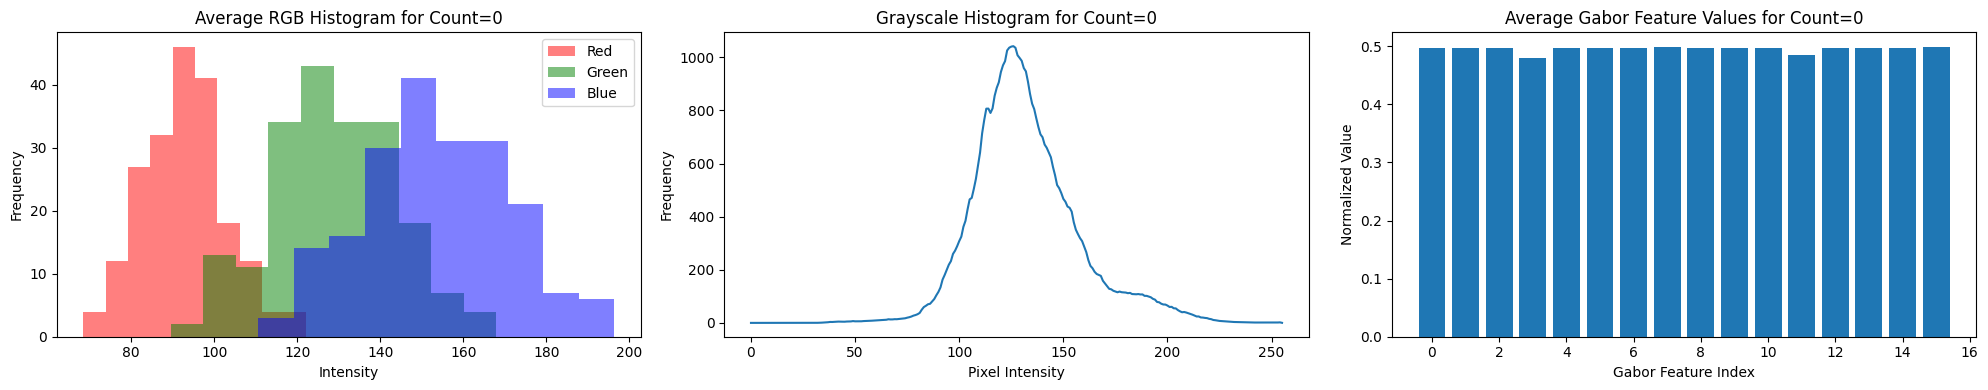

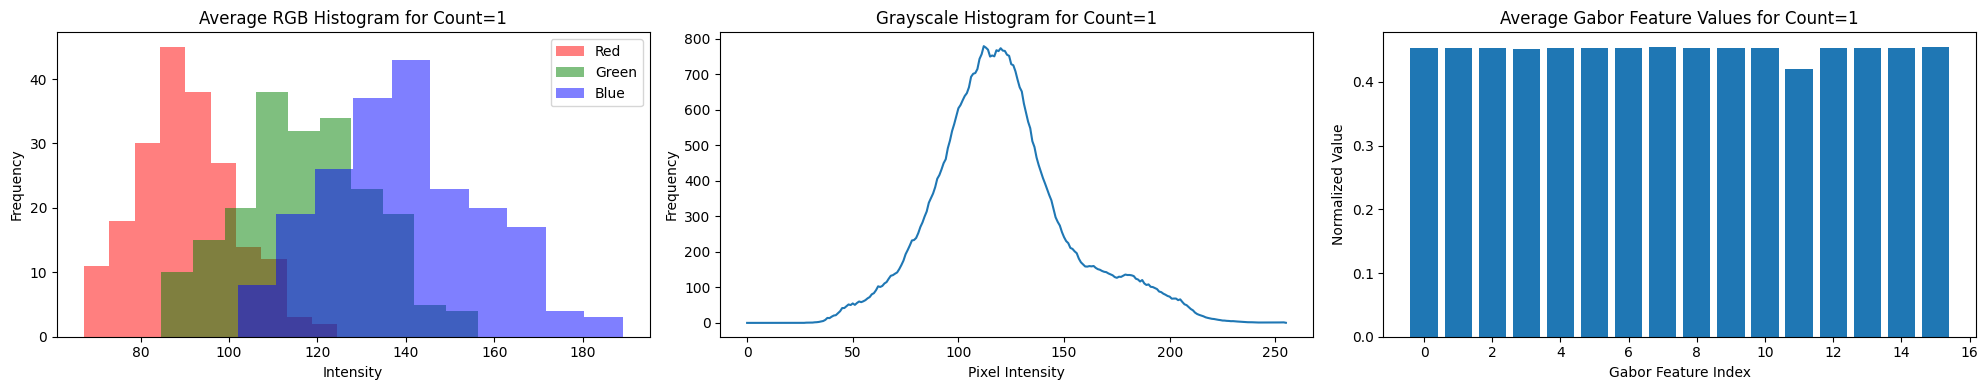

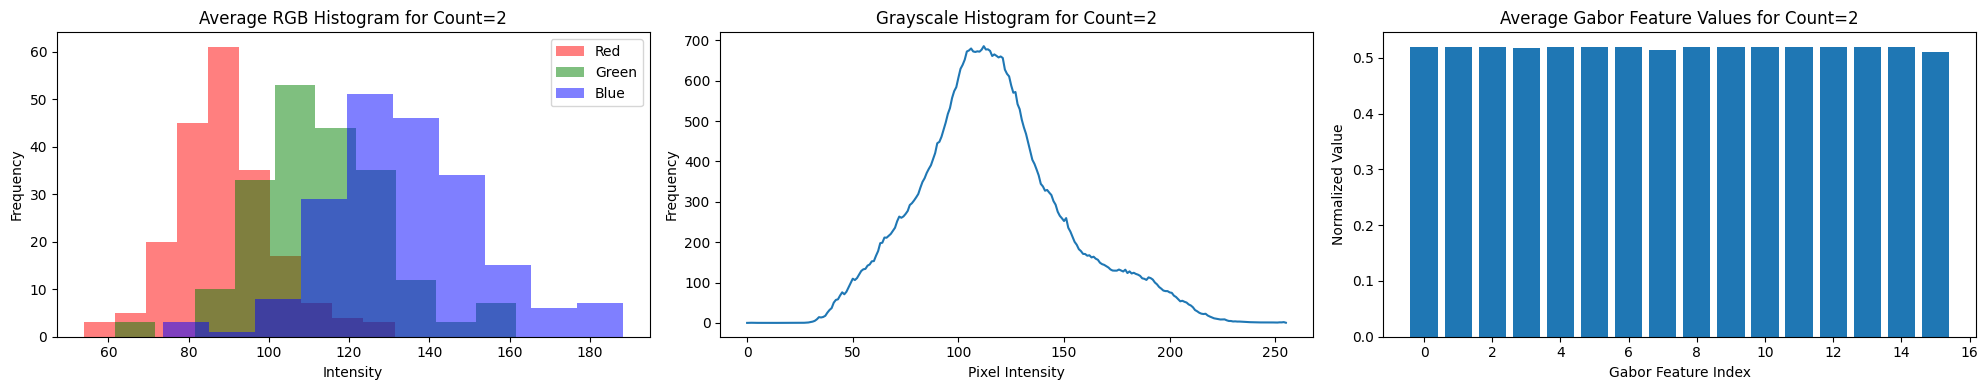

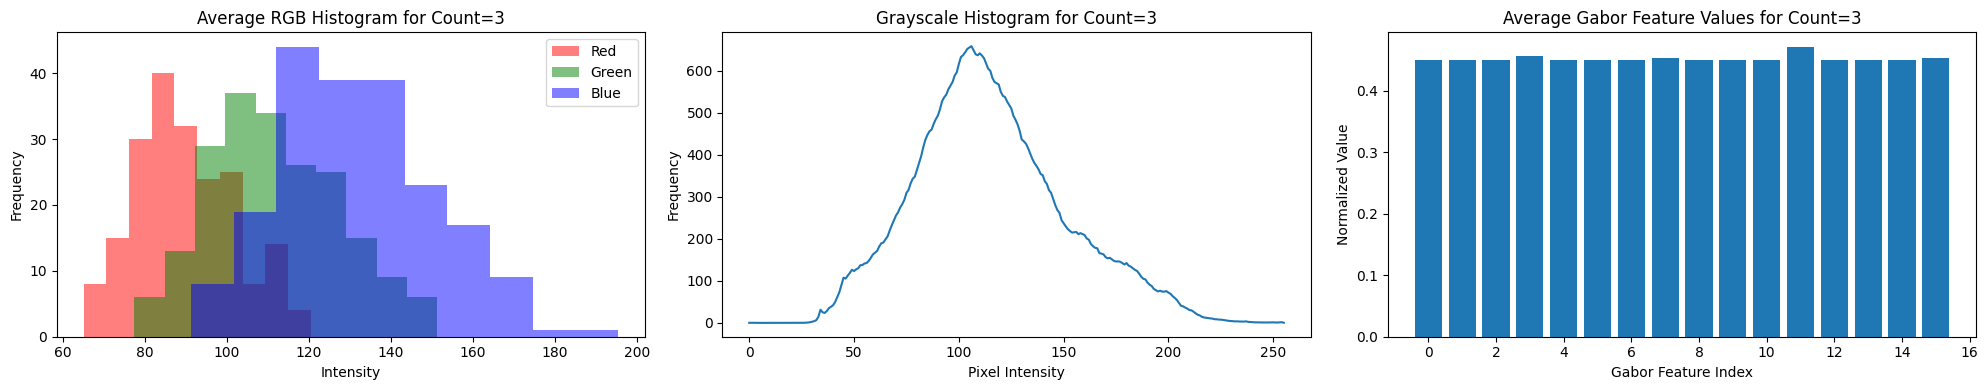

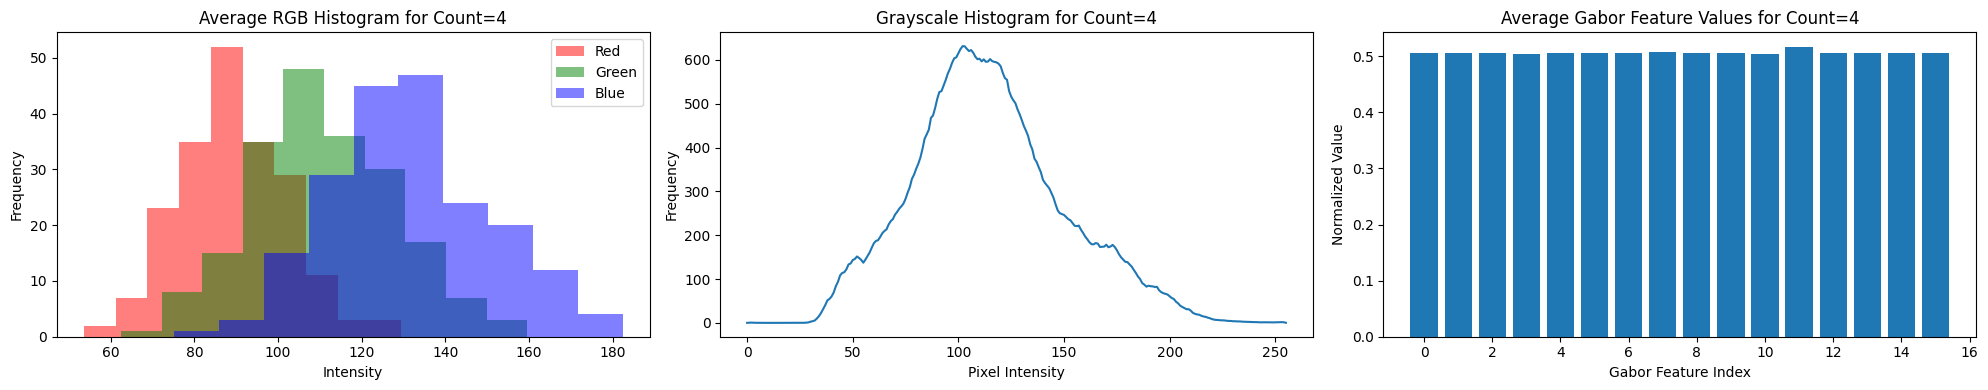

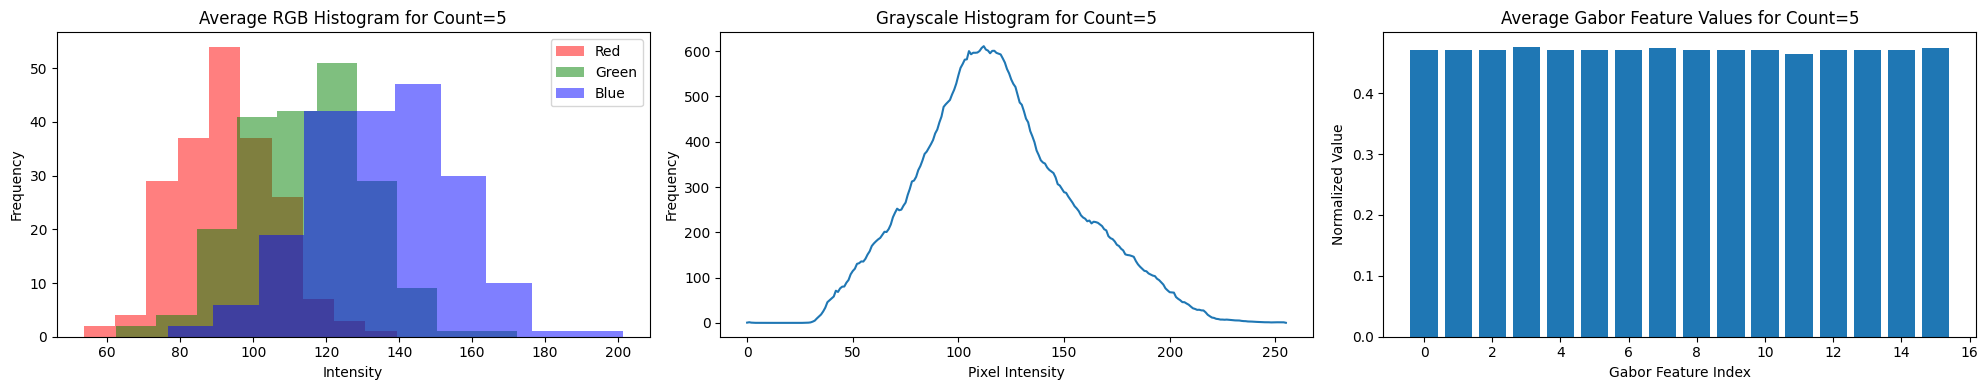

In [203]:
analyze_images(sampled_metadata_df)

By analyzing Variance of Laplacian in order to determine if an image is "blurred". In a blurry image, there is less distinction between the horizontal barrier lines and the actual objects in the bins. Therefore, the thought is to remove the "blurred" images from the model training for better accuracy. This will be based on assumption that all images taken from the bin should be with sharp image. 

With variance threshold set at 100, expected around 15% of the "blurred" images can be identified and removed from training

In [182]:
#function to determine if an image is blurred, defined as the grayscale image has laplacian variance below a threshold value 
def is_blurred(image, threshold=100):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compute the Laplacian
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    # Compute the variance of the Laplacian
    variance = laplacian.var()
    # Return True if variance is below the threshold, indicating a blurred image
    return variance < threshold

#for a given list of image filename in a dataframe, determine for each "Expected_Quantity", how many are considered blurred below the laplacian variance threshold
def analyze_blurred(qty_sampled_df, lv_threshold=100, print_image='N'):
    total_image = 0
    total_blurred_count = 0
    for qty_count in set(qty_sampled_df['expected_quantity']):
        image_count = 0
        blurred_count = 0
        for filename in list(qty_sampled_df[qty_sampled_df['expected_quantity']==qty_count].image_fname):
            image_path = os.path.join(image_source_dir, filename)
            image = cv2.imread(image_path)
            image_count += 1

            if is_blurred(image, lv_threshold):
                blurred_count += 1
                if print_image == 'Y':
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    plt.figure(figsize=[6,2])
                    plt.imshow(image_rgb)
                    plt.axis('off')  # Turn off axis labels
                    plt.show()

        total_image += image_count
        total_blurred_count += blurred_count
        print(f"Out of the {image_count} images with qty ={qty_count}, {blurred_count} of them ({round((blurred_count/image_count)*100,3)}%)found to be blurred below laplacian variance threshold {lv_threshold}")

    print(f"Analyze Blurred Outcome: Out of {total_image} total images, {total_blurred_count} images { round((total_blurred_count / total_image)*100,3)}% are blurred under threshold {lv_threshold}")

In [183]:
analyze_blurred(sampled_metadata_df, lv_threshold=100, print_image='N')

Out of the 200 images with qty =0, 104 of them (52.0%)found to be blurred below laplacian variance threshold 100
Out of the 200 images with qty =1, 34 of them (17.0%)found to be blurred below laplacian variance threshold 100
Out of the 200 images with qty =2, 26 of them (13.0%)found to be blurred below laplacian variance threshold 100
Out of the 200 images with qty =3, 17 of them (8.5%)found to be blurred below laplacian variance threshold 100
Out of the 200 images with qty =4, 25 of them (12.5%)found to be blurred below laplacian variance threshold 100
Out of the 200 images with qty =5, 33 of them (16.5%)found to be blurred below laplacian variance threshold 100
Analyze Blurred Outcome: Out of 1200 total images, 239 images 19.917% are blurred under threshold 100


In [188]:
def determine_blurred(row):
    image_path = os.path.join(image_source_dir, row)
    image = cv2.imread(image_path)

    return is_blurred(image, 100)

For image not able to pass the with variance threshold 100, a new column in data frame `blurred_image_t100` is marked "Y" to indicate the image is classified "blurred". In subsequent model training, such blurred image will be excluded from the training.  

In [189]:
sampled_metadata_df['blurred_image_t100'] = sampled_metadata_df['image_fname'].apply(lambda x: determine_blurred(x))
sampled_metadata_df.groupby('expected_quantity')[['blurred_image_t100']].value_counts()

expected_quantity  blurred_image_t100
0                  True                  104
                   False                  96
1                  False                 166
                   True                   34
2                  False                 174
                   True                   26
3                  False                 183
                   True                   17
4                  False                 175
                   True                   25
5                  False                 167
                   True                   33
Name: count, dtype: int64

With the "blurred images" filtered, run the analyze_image again for the RGB distribution, Grayscale distribution and texture analysis. 

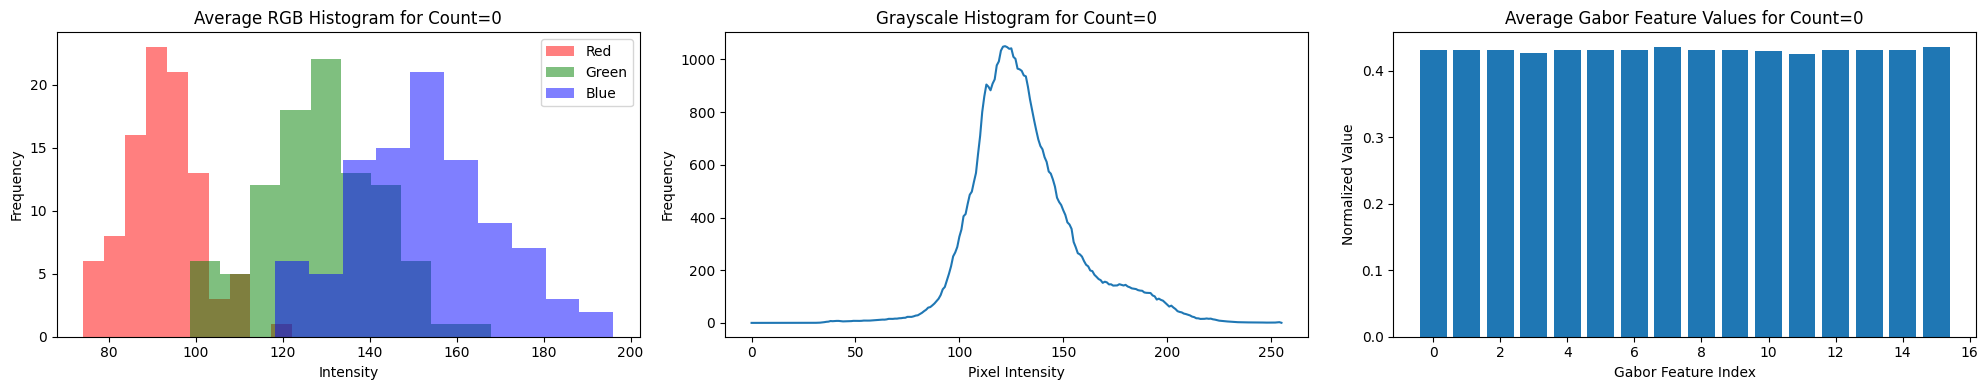

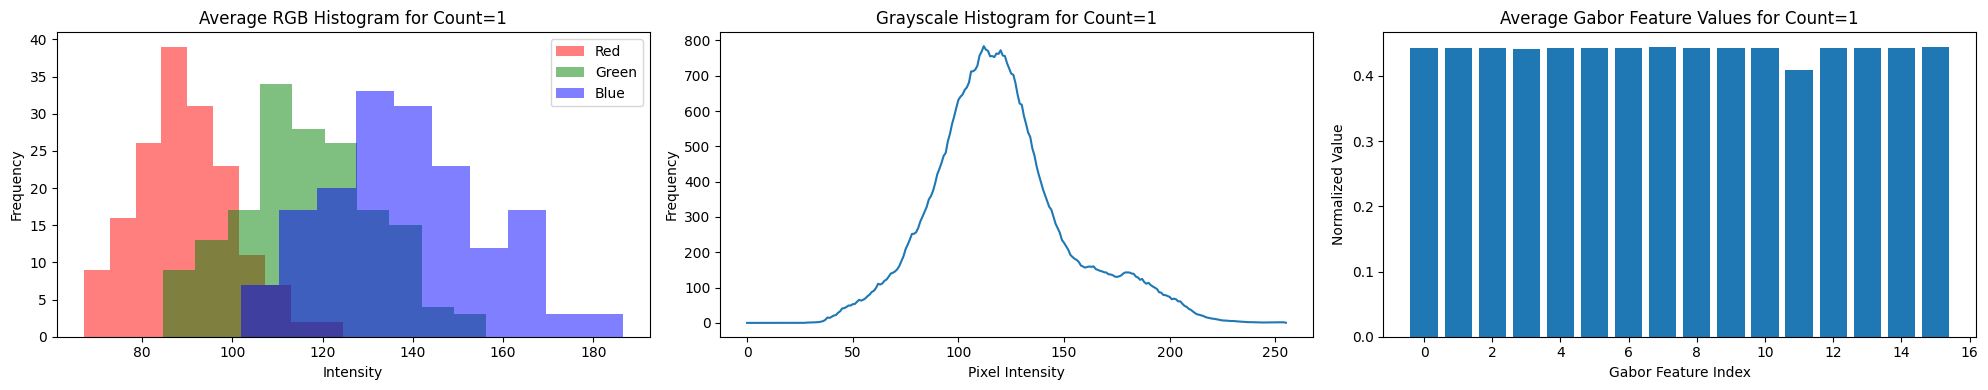

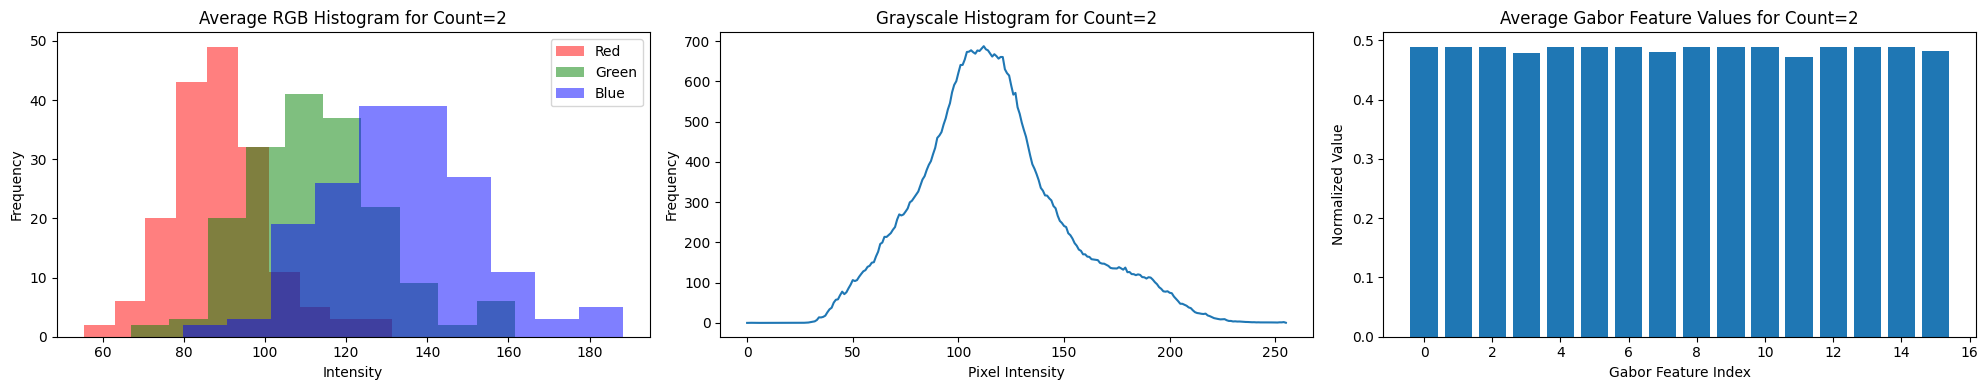

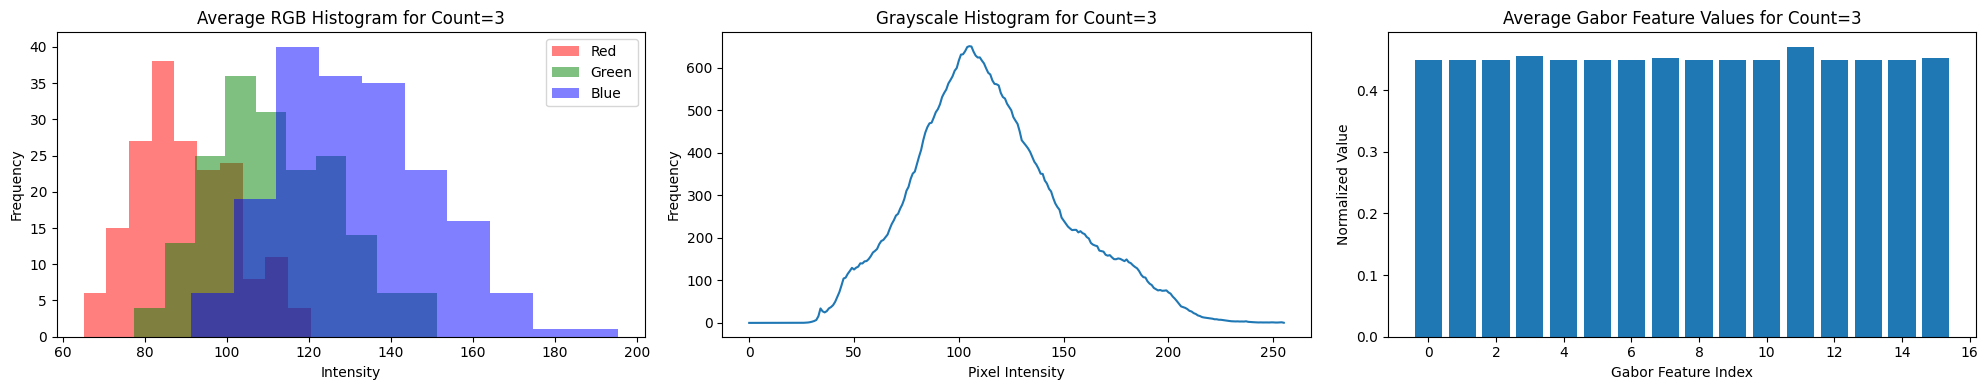

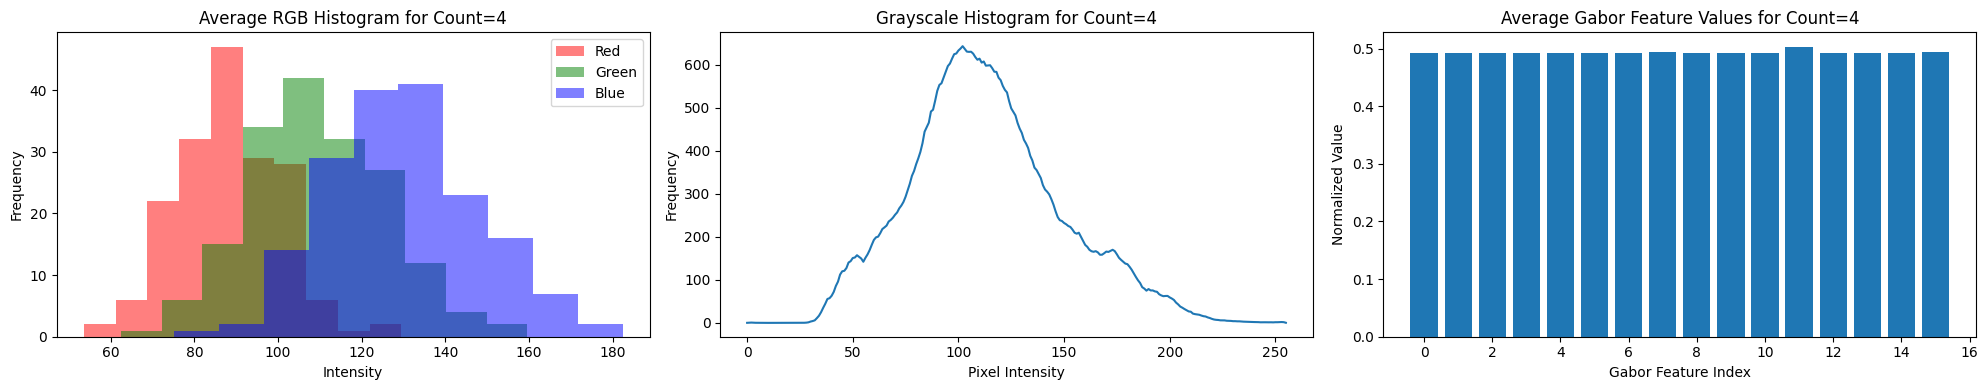

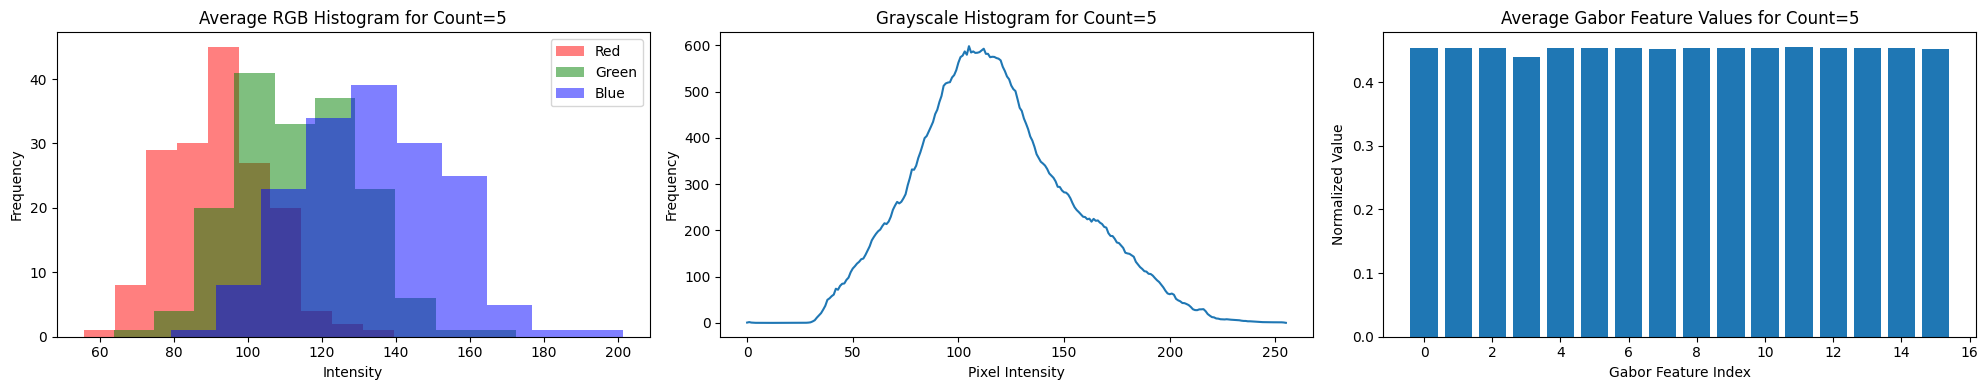

In [204]:
analyze_images(sampled_metadata_df[sampled_metadata_df['blurred_image_t100']==False])

In [190]:
metadata_classes_df['blurred_image_t100'] = metadata_classes_df['image_fname'].apply(lambda x: determine_blurred(x))
metadata_classes_df.groupby('expected_quantity')[['blurred_image_t100']].value_counts()

C:\Users\Ryan\AppData\Local\Temp\ipykernel_18524\1162538120.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_classes_df['blurred_image_t100'] = metadata_classes_df['image_fname'].apply(lambda x: determine_blurred(x))


expected_quantity  blurred_image_t100
0                  False                  5360
                   True                   4541
1                  False                 34523
                   True                   6824
2                  False                 67132
                   True                   9931
3                  False                 79327
                   True                  10931
4                  False                 71156
                   True                   9594
5                  False                 55092
                   True                   7556
Name: count, dtype: int64

With the blurred images filtered, the "blurred_image_t100" column in the dataframe provides a flag for the model evaluation, so that evaluation and training will not include the blurred images. 

Export the sampled image for reference. 

In [192]:
qty_list = "_".join("Q"+str(num) for num in class_num)
filename_suffix = '519a'  #unique identifier for easier recognized

metadata_class_pickle_file = open(f'{data_dir}/metadata_class_{qty_list}_{filename_suffix}.pkl','wb')
pickle.dump(metadata_classes_df, metadata_class_pickle_file)
metadata_class_pickle_file.close()